In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat
from orographicPrecipitation.observationsAndERA5.linearWaveModels import second_derivative_matrix

SCRATCH='/global/cscratch1/sd/qnicolas/'

from scipy.integrate import odeint,solve_ivp
import scipy.linalg as spl
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter


%load_ext autoreload
%autoreload 2
from ZBP import *

In [6]:
DZ = 20.
zz = np.arange(1000,20e3,DZ)
ww = zz*0

Ref = ZBP(zz,ww); Ref.integrate(); Ref.calc_precip(); Ref.calc_Q()
Ref.N2 = (g/Ref.TT *(np.gradient(Ref.TT,Ref.zz)+g/cp))
Madiabat = ZBP(zz,ww,epsilon=1e-6); Madiabat.integrate()

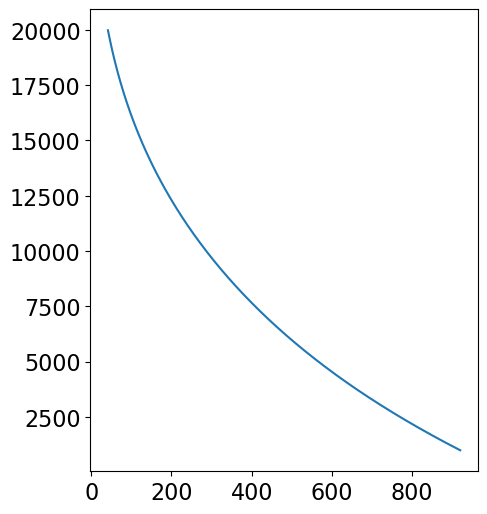

In [3]:
plt.figure(figsize=(5,6))
plt.plot(Ref.pp/100,Ref.zz)

In [30]:
#class SimulationCustom(Simulation):
#    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
#        super().__init__(path,center,dx,inp,out,pout,is_subset)
#        self.suffix2 = suffix2
#        self.T_PL_MEAN  = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
#W10S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000')
#

(1010.0, 50.0)

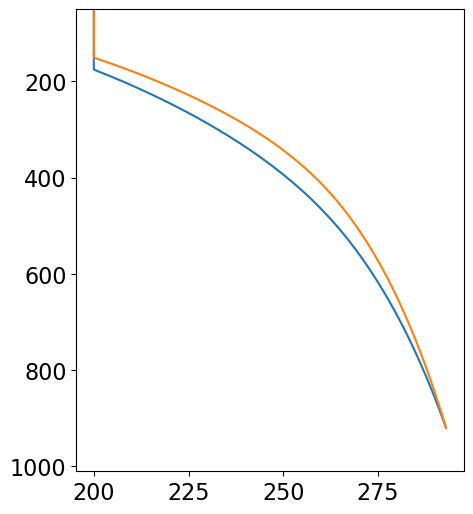

In [4]:
plt.figure(figsize=(5,6))
plt.plot(Ref.TT,Ref.pp/100)
plt.plot(Madiabat.TT,Madiabat.pp/100)
#W10S300.T_PL_MEAN[:,2200:3000].mean('distance_from_mtn').plot(y='pressure',yincrease=False)
#W10S300.T_PL_MEAN[:,1640:1660].mean('distance_from_mtn').plot(y='pressure',yincrease=False)

plt.ylim(1010,50)

In [5]:
zz = np.arange(1000,20e3,DZ)
Tprime = np.sin(zz*np.pi/10e3)
Tprime = Tprime * (Tprime>0)
tau = 86400
ww = Tprime/(tau*5e-3)

Fb = ZBP(zz,ww); Fb.integrate(); Fb.calc_precip(); Fb.calc_Q()
print("pred: %.3f, actual:%.3f"%( np.trapz((Ref.pp/Rd/Ref.TT)*Fb.ww*(np.gradient(Ref.TT,Ref.zz)*cp+g),Ref.zz)/Lv*86400 , (Fb.precip-Ref.precip)*86400 ))

pred: 1.210, actual:1.285


In [6]:
zz = np.arange(1000,20e3,DZ)
Tprime = -np.sin(zz*np.pi/5e3)*(zz<10e3)
tau = 86400
ww = Tprime/(tau*5e-3)

Sb = ZBP(zz,ww); Sb.integrate(); Sb.calc_precip(); Sb.calc_Q()
print("pred: %.3f, actual:%.3f"%( np.trapz((Ref.pp/Rd/Ref.TT)*Sb.ww*(np.gradient(Ref.TT,Ref.zz)*cp+g),Ref.zz)/Lv*86400 , (Sb.precip-Ref.precip)*86400 ))

pred: -0.699, actual:-0.681


In [7]:
zz = np.arange(1000,20e3,DZ)
Tprime = -np.sin(zz*np.pi/5e3)*(zz<10e3)
tau = 86400
ww = Tprime/(tau*5e-3)

Sb = ZBP(zz,-ww); Sb.integrate(); Sb.calc_precip(); Sb.calc_Q()
print("pred: %.3f, actual:%.3f"%( np.trapz((Ref.pp/Rd/Ref.TT)*Sb.ww*(np.gradient(Ref.TT,Ref.zz)*cp+g),Ref.zz)/Lv*86400 , (Sb.precip-Ref.precip)*86400 ))

pred: 0.699, actual:0.739


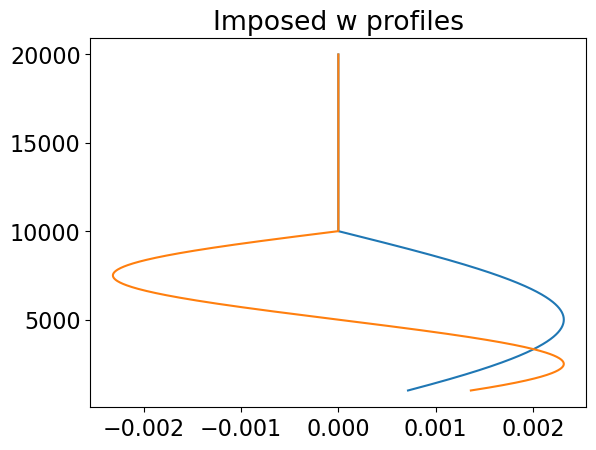

In [8]:
plt.title('Imposed w profiles')
plt.plot(Fb.ww,Fb.zz)
plt.plot(Sb.ww,Sb.zz)

(1010.0, 100.0)

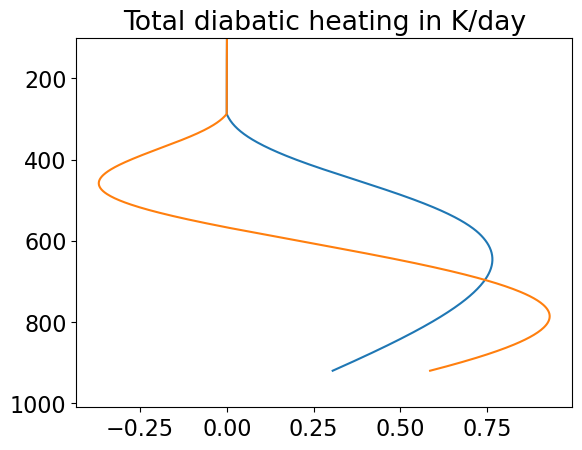

In [9]:
plt.title('Total diabatic heating in K/day')
plt.plot(Fb.Q/(Fb.rho_*cp)*86400,Fb.pp/100)
plt.plot(Sb.Q/(Sb.rho_*cp)*86400,Sb.pp/100)
plt.ylim(1010,100)

(1010.0, 100.0)

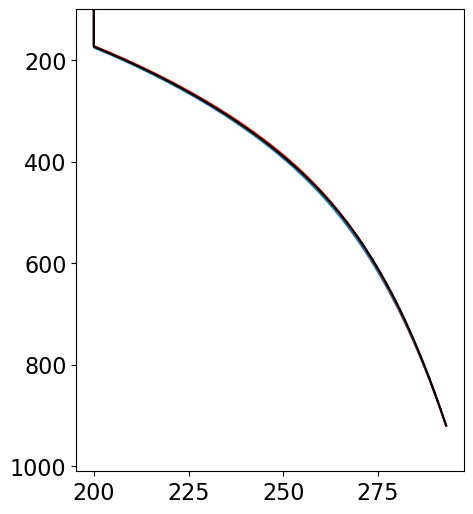

In [10]:
plt.figure(figsize=(5,6))
plt.plot(Ref.TT,Ref.pp/100)
plt.plot(Fb.TT,Fb.pp/100,color='r')
plt.plot(Sb.TT,Sb.pp/100,color='k')
plt.ylim(1010,100)

(1010.0, 100.0)

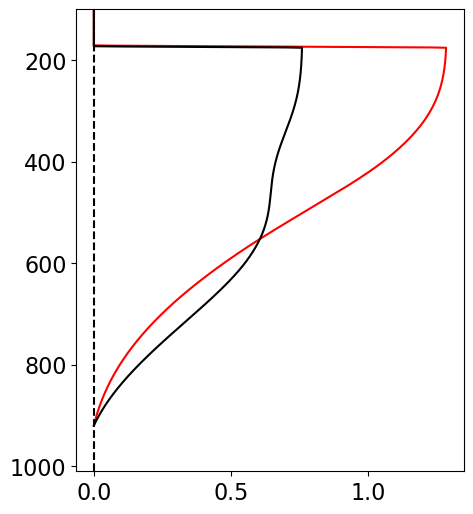

In [11]:
plt.figure(figsize=(5,6))
plt.plot(Fb.TT-Ref.TT,Ref.pp/100,color='r')
plt.plot(Sb.TT-Ref.TT,Ref.pp/100,color='k')
plt.axvline(0.,linestyle='--',color='k')
plt.ylim(1010,100)

# DGW coupling

In [12]:
def dgw_mode(z_,rhs_):
    z = z_[z_<11e3]
    rhs = rhs_[z_<11e3]
    n = len(z)
    dz = z[1]-z[0]
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    A[-1,-1] = 1
    
    b = np.zeros(n)
    b[1:-1]= dz**2 * rhs[1:-1]
    
    w = np.linalg.solve(A,b)
    w_tot = np.concatenate((w,0*z_[z_>=11e3]))
    return w_tot

def couple_dgw(Zbpa,tau,k,TTref,qqref):
    rhoww=0*Zbpa.zz*1j
    rhoww1 = rhoww
    
    c=0.6
    
    ws=[]

    for i in range(40):
        print(i, end = ' ')
        try:
            Zbpa.ww = np.real(c*rhoww+(1-c)*rhoww1)
            Zbpa.integrate()
            rhs=-tau*k**2*g*((Zbpa.TT/TTref)-1)
            rhoww1=rhoww
            rhoww = dgw_mode(Zbpa.zz,rhs)
            ws.append(rhoww)
        except ValueError:
            return ws

    return np.real(ws)

In [13]:
zz = np.arange(1000,20e3,DZ)
ww = zz*0
Ref1 = ZBP(zz,ww,Ts=294.); Ref1.integrate()
ws = couple_dgw(Ref1,86400,1e-6,Ref.TT,Ref.qq)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

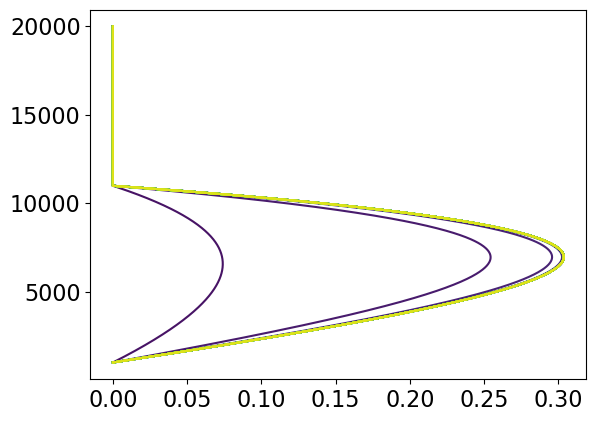

In [14]:
N=40
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(ws[i],Ref.zz,color=colors[i])

# ZBP with large scale forcing

In [15]:
zz = np.arange(1000,20e3,DZ)
ww = 0.001*np.sin(zz*np.pi/10e3)
ww = ww * (ww>0)

k = 2*np.pi/100e3; U0=10.
alpha = Ref.rho_*k*U0 #* (Ref.TT>Tt)

Ref2 = ZBPls(zz,ww,alpha,Ref.TT,Ref.qq); Ref2.integrate(); Ref2.calc_precip(); Ref2.calc_Q()
Ref3 = ZBP(zz,ww); Ref3.integrate(); Ref3.calc_precip(); Ref3.calc_Q()

In [16]:
ww = np.eye(len(ww))[100]*0.5
%time Ref22 = ZBPls(zz,ww,alpha,Ref.TT,Ref.qq); Ref22.integrate(); Ref22.calc_precip(); Ref22.calc_Q()

CPU times: user 122 ms, sys: 2.91 ms, total: 125 ms
Wall time: 122 ms


(1010.0, 100.0)

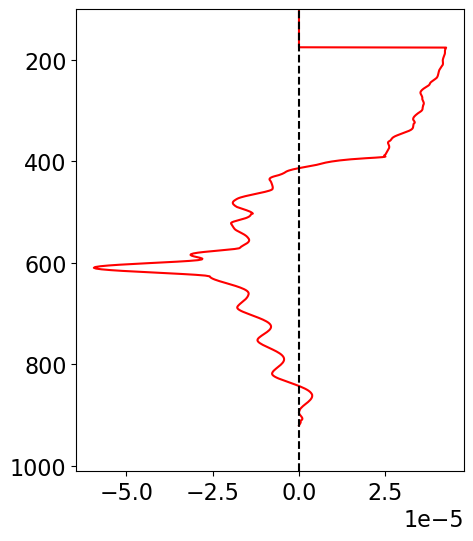

In [17]:
plt.figure(figsize=(5,6))
plt.plot(Ref22.TT-Ref.TT,Ref.pp/100,color='r')
plt.axvline(0.,linestyle='--',color='k')
plt.ylim(1010,100)

(1010.0, 100.0)

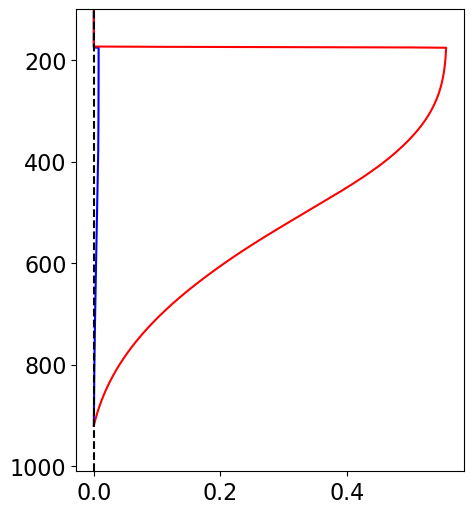

In [18]:
plt.figure(figsize=(5,6))
plt.plot(Ref2.TT-Ref.TT,Ref.pp/100,color='b')
plt.plot(Ref3.TT-Ref.TT,Ref.pp/100,color='r')
plt.axvline(0.,linestyle='--',color='k')
plt.ylim(1010,100)

(1010.0, 100.0)

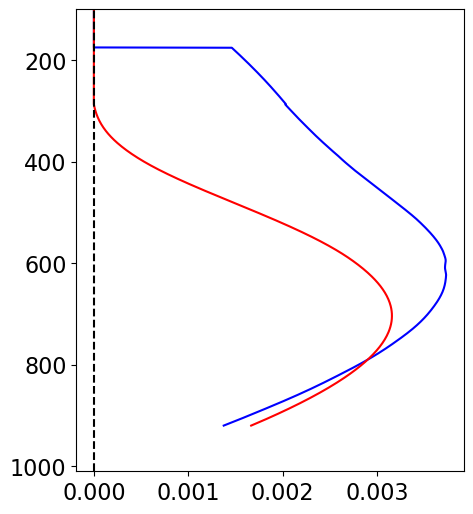

In [19]:
plt.figure(figsize=(5,6))
plt.plot(Ref2.Q,Ref.pp/100,color='b')
plt.plot(Ref3.Q,Ref.pp/100,color='r')
plt.axvline(0.,linestyle='--',color='k')
plt.ylim(1010,100)

(1010.0, 100.0)

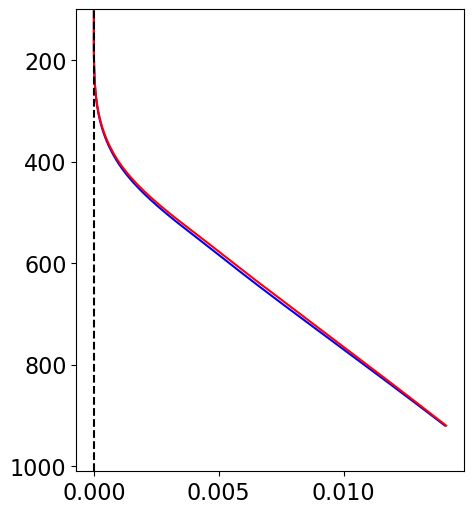

In [20]:
plt.figure(figsize=(5,6))
plt.plot(Ref2.qq,Ref.pp/100,color='b')
plt.plot(Ref3.qq,Ref.pp/100,color='r')
plt.axvline(0.,linestyle='--',color='k')
plt.ylim(1010,100)

## Linearizing

In [21]:
zz = np.arange(1000,20e3,DZ)
k = 2*np.pi/100e3; U0=10.
alpha = Ref.rho_*k*U0 

Ref2 = ZBPls(zz,0*zz,alpha,Ref.TT,Ref.qq)

In [22]:
Ref2.integrate(); Ref2.calc_precip(); Ref2.calc_Q()

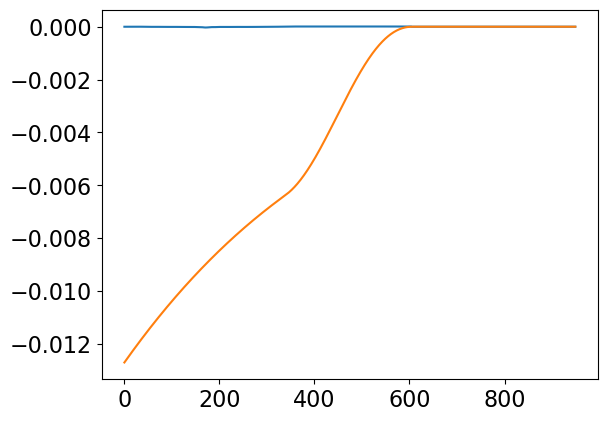

In [23]:
plt.plot(Ref2.Q)
plt.plot(Qrad_Jpm3ps(Ref2.TT,Ref2.pp))

In [24]:
%%time
dQdw = []
ws = np.eye(len(ww))
eps = 1e-4
for i in range(len(ww)):
    Ref2.ww = eps*ws[i]
    Ref2.integrate(); Ref2.calc_precip(); Ref2.calc_Q()
    dQdw.append(Ref2.Q/eps)

KeyboardInterrupt: 

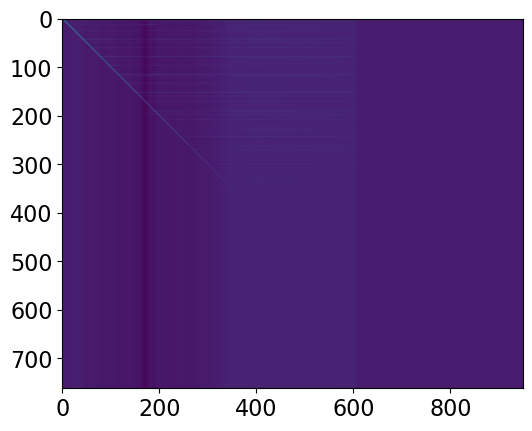

In [26]:
plt.imshow(dQdw)

In [43]:
%%time
dQdw2 = []
ws = np.eye(len(ww))
eps = 1e-4
for i in range(len(ww)//5):
    Ref.ww = eps*ws[5*i]
    Ref.integrate(); Ref.calc_precip(); Ref.calc_Q()
    dQdw2.append(Ref.Q/eps)

CPU times: user 56.8 s, sys: 121 ms, total: 57 s
Wall time: 56.8 s


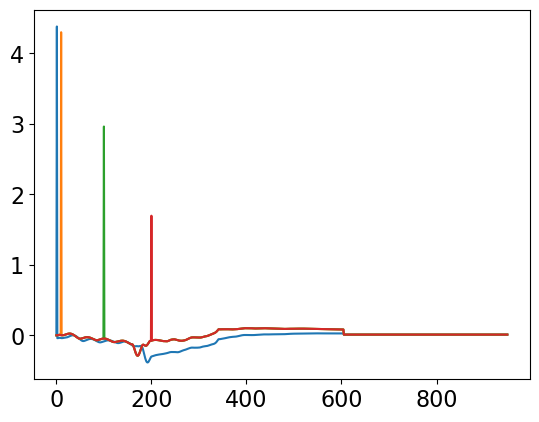

In [28]:
plt.plot(dQdw[1])
plt.plot(dQdw[10])
plt.plot(dQdw[100])
plt.plot(dQdw[200])

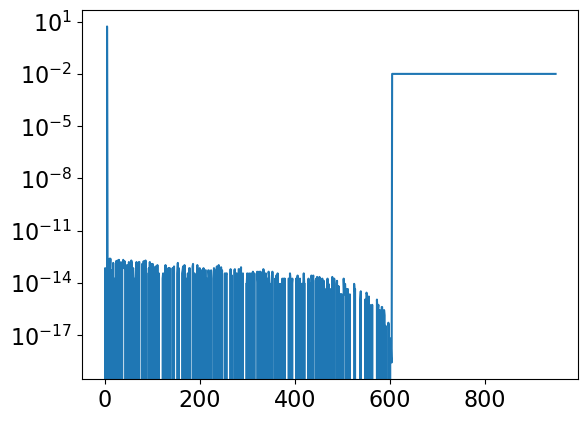

In [45]:
plt.plot(dQdw2[1])
plt.yscale('log')

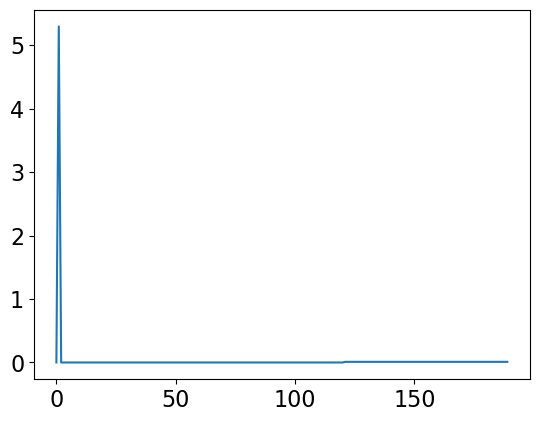

In [269]:
plt.plot(dQdw2[1])

# orographic GW model

## With damping

In [60]:
def gw_mode_orig(z,lz2,k,hhatk,U0):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = 0, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -= dz * 1j* mtop
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    
    return np.linalg.solve(A,b)
    A = csc_matrix(A)
    return spsolve(A,b)

def gw_mode_new(z,lz2,k,hhatk,U0,rhs,mode='norhs',dirichlet_top_bc=False,K0=0,rhs2=0):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = 0, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    if mode=='rhs':
        A = D2 + dz**2*np.diag((K0**2-k**2)*np.ones(n))
    elif mode=='norhs':
        A = D2 + dz**2*np.diag(K0**2+lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    if dirichlet_top_bc:
        A[-1,-1] = 1.
    else:
        A[-1,-3:] = np.array([1,-4,3])/2
        A[-1,-1] -= dz * 1j* mtop
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    if mode=='rhs':
        b[1:-1] = dz**2*rhs[1:-1]
    #b += dz**2*K0**2*rhs2
    b[1:-1] += dz**2*K0**2*rhs2[1:-1]
    
    return np.linalg.solve(A,b)


In [241]:
N2_ref = (g/Ref.TT *(np.gradient(Ref.TT,Ref.zz)+g/cp))
U0=10.
k0 = 2*np.pi/100e3
hhatk0 = 1.
#ww = gw_mode_orig(Ref.zz,N2_ref/U0**2,k0,hhatk0,U0)
ww_ref = gw_mode_new(Ref.zz,N2_ref/U0**2,k0,hhatk0,U0,0.,'norhs')

Tprime = -Ref.TT * N2_ref*ww_ref/(1j*k0*U0*g)
rhs = 1j * k0 * g / U0 * Tprime/Ref.TT
#rhs = -N2_ref/U0**2*ww

ww2 = gw_mode_new(Ref.zz,N2_ref/U0**2,k0,hhatk0,U0,rhs,'rhs')
ww3 = gw_mode_new(Ref.zz,N2_ref/U0**2,k0,hhatk0,U0,np.zeros(len(Ref.zz)),'rhs')

In [154]:
# with drag
eps = 1e-5
lz2_drag = N2_ref/(U0**2-eps**2/k0**2)
ww_ref_drag = gw_mode_new(Ref.zz,lz2_drag,k0,hhatk0,U0,0.,'norhs')

Tprime = -Ref.TT/g * N2_ref*ww_ref/(1j*k0*U0+eps)
rhs = - k0**2 * g * Tprime/Ref.TT / (1j*k0*U0+eps)
#rhs = -lz2_drag*ww
#
ww2 = gw_mode_new(Ref.zz,N2_ref/(U0**2-eps**2/k0**2),k0,hhatk0,U0,rhs,'rhs')
#ww3 = gw_mode_new(Ref.zz,N2_ref/U0**2,k0,hhatk0,U0,np.zeros(len(Ref.zz)),'rhs')

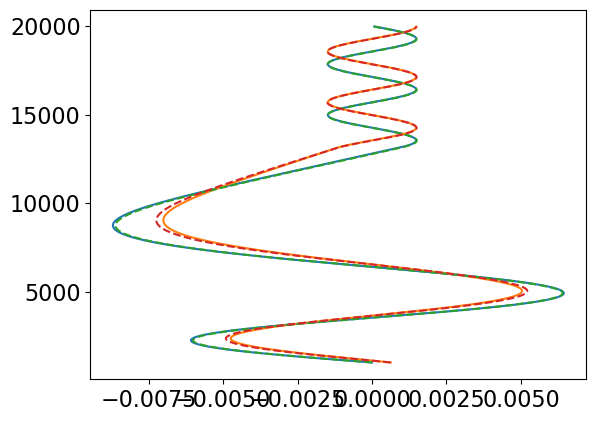

In [155]:
#plt.plot(np.real(ww_ref),Ref.zz)
#plt.plot(np.imag(ww_ref),Ref.zz)
plt.plot(np.real(ww_ref_drag),Ref.zz)
plt.plot(np.imag(ww_ref_drag),Ref.zz)
plt.plot(np.real(ww2),Ref.zz,linestyle='--')
plt.plot(np.imag(ww2),Ref.zz,linestyle='--')
#plt.plot(np.imag(ww3),Ref.zz,linestyle='--',color='k')

In [8]:
# Simple coupling
def couple_simple(Zbpa,k,hhatk,U0,ww=None,eps=1e-5):
    TTref = Zbpa.TT
    N2_ref = (g/TTref *(np.gradient(TTref,Zbpa.zz)+g/cp))
    #lz2_drag = N2_ref/(U0**2-eps**2/k0**2)
    lz2 = N2_ref/U0**2
    if ww is None:
        ww=0*Zbpa.zz*1j
    ww1 = ww
    
    Tprime = 0*Zbpa.zz*1j
    
    amps = []
    ws = []
    c=0.01
    for i in range(10):
        print(i, end = ' ')
        Tprime1=Tprime
        Tprime = - TTref * N2_ref * ((1-c)*ww1 + c*ww) / (1j*k*U0*g)
        rhs = 1j * k * g / U0 * ((1-c)*Tprime1 + c*Tprime)/TTref
        #Tprime = -TTref/g * N2_ref*((1-c)*ww1 + c*ww)/(1j*k*U0+eps)
        #rhs = - k**2 * g * Tprime/TTref / (1j*k*U0+eps)
        ww1 = ww
        ww = gw_mode_new(Zbpa.zz,lz2,k,hhatk,U0,rhs,'rhs')
        amps.append(np.sum(np.abs(ww)**2))
        ws.append(ww)

    #xx = np.arange(-1000,1000)*1e3
    #w_full = np.real(ww[None,:]*np.exp(1j*k*xx[:,None]))
    #w_xr = xr.DataArray(w_full,coords={'distance_from_mtn':xx/1000,'altitude':Zbpa.zz/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',Zbpa.pp/100)})
    return amps,ws

In [198]:
k = 2*np.pi/100e3
amps,ws = couple_simple(Ref,k,0.001,10.)
amps2,ws2 = couple_simple(Ref,k,0.001,10.,ww_ref,eps=1e-3)

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

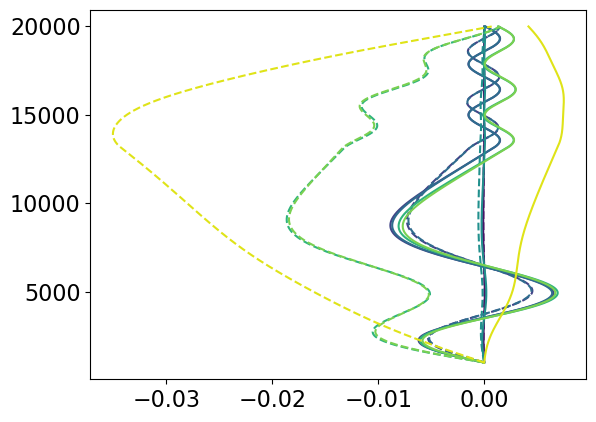

In [199]:
N=7
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws2[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws2[i]),Ref.zz,color=colors[i],linestyle='--')
#plt.plot(amps)
#plt.plot(amps2)
#plt.yscale('log')

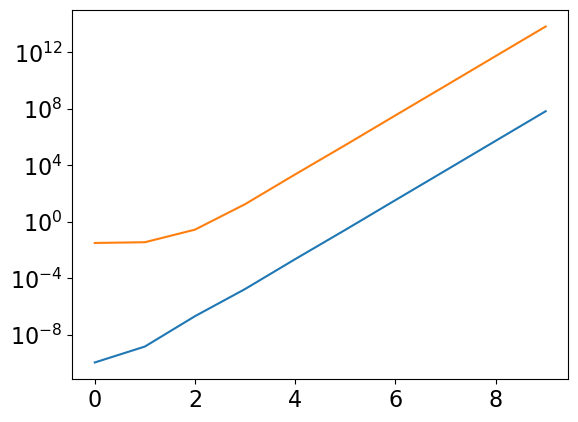

In [159]:
plt.plot(amps)
plt.plot(amps2)
plt.yscale('log')

## Even simpler coupling

In [241]:
# Simple coupling
def couple_vsimple(Zbpa,k,hhatk,U0,ww=None,eps=1e-5):
    TTref = Zbpa.TT
    N2_ref = (g/TTref *(np.gradient(TTref,Zbpa.zz)+g/cp))
    #lz2_drag = N2_ref/(U0**2-eps**2/k0**2)
    lz2 = N2_ref/U0**2
    if ww is None:
        ww=0*Zbpa.zz*1j
    ww1 = ww
    amps = []
    ws = []
    c=1.
    K0=0.15
    for i in range(20):
        print(i, end = ' ')

        rhs = -N2_ref/U0**2 * ((1-c)*ww1 + c*ww)
        ww1 = ww
        ww = gw_mode_new(Zbpa.zz,lz2,k,hhatk,U0,rhs,'rhs',False,K0=K0,rhs2=((1-c)*ww1 + c*ww))
        amps.append(np.sum(np.abs(ww)**2))
        ws.append(ww)
    return amps,ws

def couple_vsimple2(Zbpa,k,hhatk,U0,mui,mi,wi):
    dz=Zbpa.zz[1]-Zbpa.zz[0]
    lz2 = Zbpa.N2/U0**2
    ww=0*Zbpa.zz*1j
    ww1 = ww
    amps = []
    ws = []
    c=1.
    K0=10e-3
    for i in range(60):
        ws.append(ww)
        print(i, end = ' ')

        rhs = -dz**2*lz2 * ((1-c)*ww1 + c*ww) 
        rhs[0] = 1j*k*U0*hhatk
        rhs[-1] = 0.
        
        rhs += K0*((1-c)*ww1 + c*ww) 
        
        ww = np.dot( np.dot(np.conj(mi),rhs)/(mui+K0) , wi)
        amps.append(np.sum(np.abs(ww)**2))
        
    return amps,ws

In [111]:
k = 2*np.pi/100e3
amps,ws = couple_vsimple(Ref,k,1.,10.)
#amps2,ws2 = couple_vsimple(Ref,k,0.001,10.,ww_ref,eps=2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [242]:
N=10#len(lambdai)
amps,ws = couple_vsimple2(Ref,k,1.,10.,lambdai[:N],li[:N],vi[:N])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

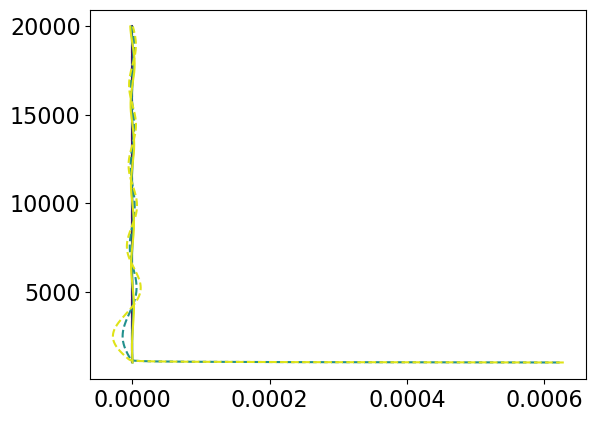

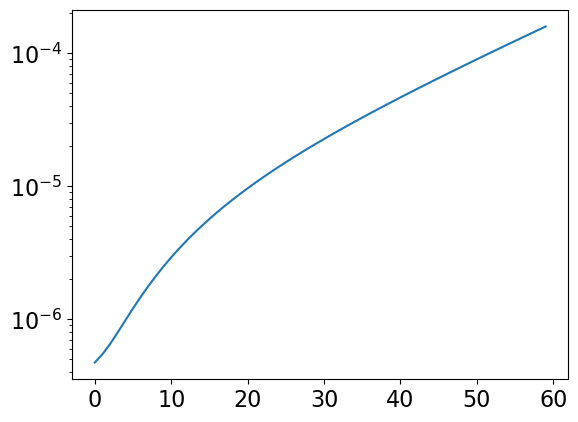

In [243]:
N=3
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')

plt.figure()
plt.plot(amps)
plt.yscale('log')

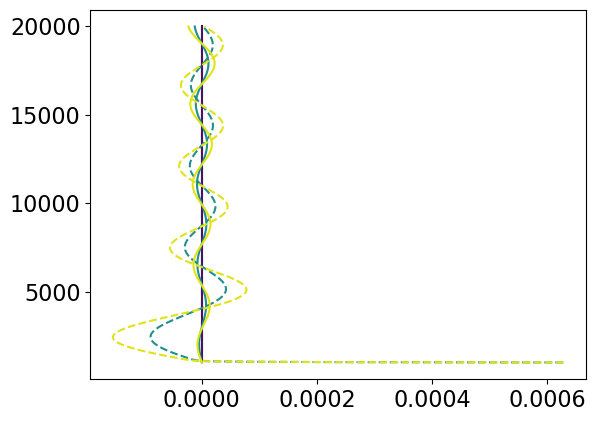

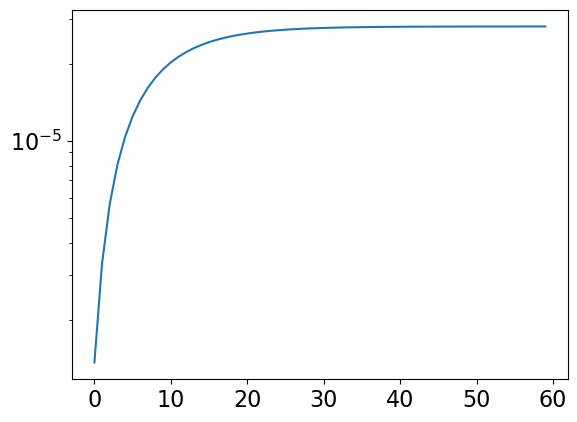

In [224]:
N=3
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')

plt.figure()
plt.plot(amps)
plt.yscale('log')

In [221]:
DZ**2*np.max(Ref.N2)/U0**2

0.0019170537848605578

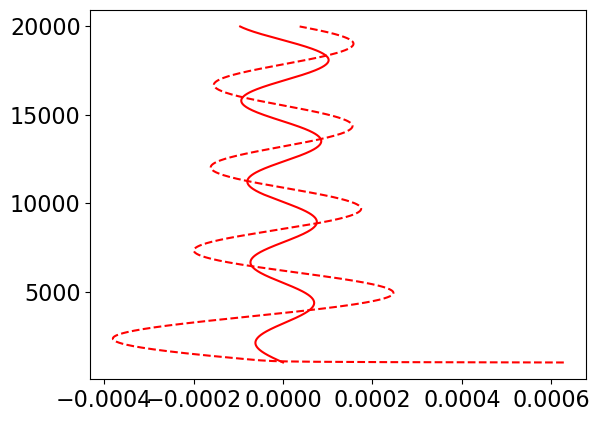

In [225]:
rhs = np.zeros(len(vi))*1j
rhs[0] = 1j*2*np.pi/100e3*10.*1.
N=10
WTEST = np.dot( np.dot(np.conj(li[:N]),rhs)/(lambdai[:N]+DZ**2*np.mean(Ref.N2)/U0**2) , vi[:N])
plt.plot(np.real(WTEST),Ref.zz,color='r')
plt.plot(np.imag(WTEST),Ref.zz,color='r',linestyle='--')


In [196]:
def makeA(z,lz2,k,mode='norhs',dirichlet_top_bc=False,K0=0):
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    if mode=='rhs':
        A = D2 + dz**2*np.diag((K0**2-k**2)*np.ones(n))
    elif mode=='norhs':
        A = D2 + dz**2*np.diag(K0**2+lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    if dirichlet_top_bc:
        A[-1,-1] = 1.
    else:
        A[-1,-3:] = np.array([1,-4,3])/2
        A[-1,-1] -= dz * 1j* mtop
    return A

In [197]:
U0=10;k0=2*np.pi/100e3
lambdai,li,vi = spl.eig(makeA(Ref.zz,Ref.N2/U0**2,k0,mode='rhs'),left=True)
order = np.argsort(-np.real(lambdai))
lambdai = lambdai[order]
vi = vi[:,order].T; li = li[:,order].T
li = li/np.diagonal(np.dot(np.conj(li),vi.T))[:,None]


In [144]:
print(np.real(lambdai[:10]))

[ 1.00000000e+00  7.20913145e-01 -1.25187236e-05 -4.53342509e-05
 -1.00015445e-04 -1.76543074e-04 -2.74884959e-04 -3.94988240e-04
 -5.36763973e-04 -7.00054545e-04]


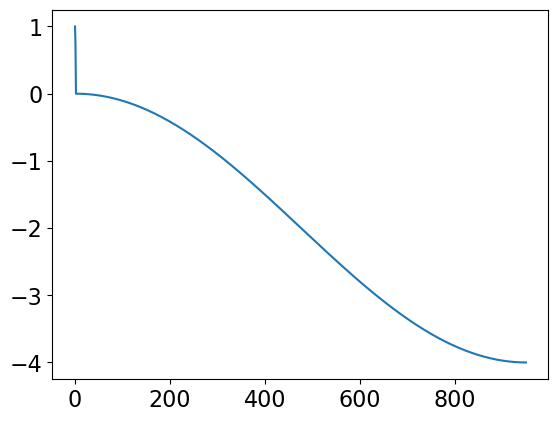

In [145]:
plt.plot(np.real(lambdai))

## with a minimization technique

In [263]:
def calc_sol(z,lz2,k,hhatk,U0,rhs=False):
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1.
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -= dz * 1j* mtop
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    if rhs:
        b[1:-1] = 2e-8
    
    return np.linalg.solve(A,b)

def calc_modes(z,lz2,k,hhatk,U0):    
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1.
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -= dz * 1j* mtop
    
    return spl.eig(A,left=True)

def to_minimize(coefs,lambdai,wi):
    nc = len(coefs)//2
    coefs2 = coefs[:nc]+1j*coefs[nc:]
    n = len(wi[0])
    b = 1j*np.zeros(n)
    b[0] = 1j*2*np.pi/100e3*10.*1.
    b[1:-1] = 2e-8    
    misfit = np.abs(np.dot(lambdai*coefs2,wi) - b)**2
    return 1e15*(np.sum(misfit))

def to_minimize_vec(coefs,lambdai,wi):
    nc = len(coefs)//2
    coefs2 = coefs[:nc]+1j*coefs[nc:]
    n = len(wi[0])
    b = 1j*np.zeros(n)
    b[0] = 1j*2*np.pi/100e3*10.*1.
    b[1:-1] = 2e-8    
    return np.abs(np.dot(lambdai*coefs2,wi) - b)**2

# Simple gradient descent
def estimate_gradient(coefs,lambdai,wi):
    eps = 1e-6
    bases = np.eye(len(coefs))
    ref = to_minimize(coefs,lambdai,wi)
    return np.array([-(to_minimize(coefs-eps*bases[i],lambdai,wi)-ref)/eps for i in range(len(wi))])

In [246]:
ww0 = calc_sol(Ref.zz,Ref.N2/U0**2,2*np.pi/100e3,1.,10.)
wwtrue = calc_sol(Ref.zz,Ref.N2/U0**2,2*np.pi/100e3,1.,10.,rhs=True)

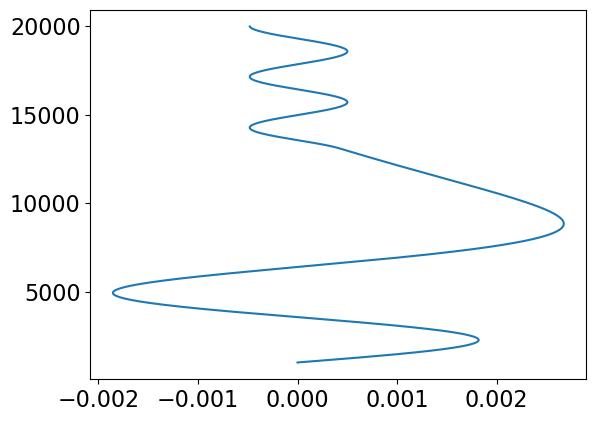

In [247]:
#plt.plot(ww0,Ref.zz)
plt.plot(wwtrue-ww0,Ref.zz)

In [202]:
#wft = np.fft.fft(ww0)
#wi = np.array([np.exp(2*1j*n*np.pi*Ref.zz/20e3) for n in range(-10,10)])
#coefs0 = np.concatenate((wft[-N:],wft[:N]))/950.
#trunc_w = np.dot(coefs0,wi)

In [248]:
from scipy.optimize import minimize

In [249]:
lambdai,li,vi = calc_modes(Ref.zz,Ref.N2/U0**2,2*np.pi/100e3,1.,10.)
order = np.argsort(-np.real(lambdai))
lambdai = lambdai[order]
vi = vi[:,order].T;li = li[:,order].T
li = li/np.diagonal(np.dot(np.conj(li),vi.T))[:,None]

In [250]:
N=30
mui = lambdai[:N]
wi = vi[:N]
mi = li[:N]


In [253]:
n = len(wi[0])
b = 1j*np.zeros(n)
b[0] = 1j*2*np.pi/100e3*10.*1.
b[1:-1] = 2e-8    

coefs_true = np.dot(np.conj(mi),b)/mui
testt2 = np.dot(coefs_true,wi)

In [264]:
coefs = np.zeros(2*len(wi))
%time test = minimize(to_minimize,coefs,args=(mui,wi),bounds=[(-0.01,0.01)]*len(coefs),method='Nelder-Mead')#,method='L-BFGS-B',jac='3-point',options={'ftol':1e-20,'gtol':1e-10})
coefs2= test.x[:len(wi)]+1j*test.x[len(wi):]
whom2 = np.dot(coefs2,wi)

CPU times: user 1.15 s, sys: 577 ms, total: 1.73 s
Wall time: 866 ms


In [265]:
to_minimize(np.concatenate((np.real(coefs_true),np.imag(coefs_true))),mui,wi)

67425792.82998982

In [266]:
to_minimize(test.x,mui,wi)

57599088.11279485

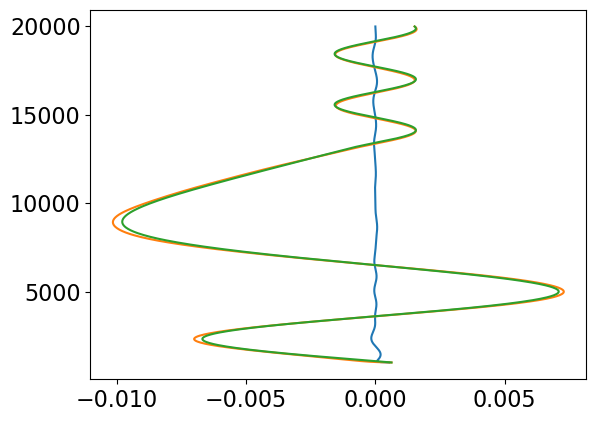

In [267]:
plt.plot(np.imag(whom2),Ref.zz)
plt.plot(np.imag(testt2),Ref.zz)
plt.plot(np.imag(wwtrue),Ref.zz)

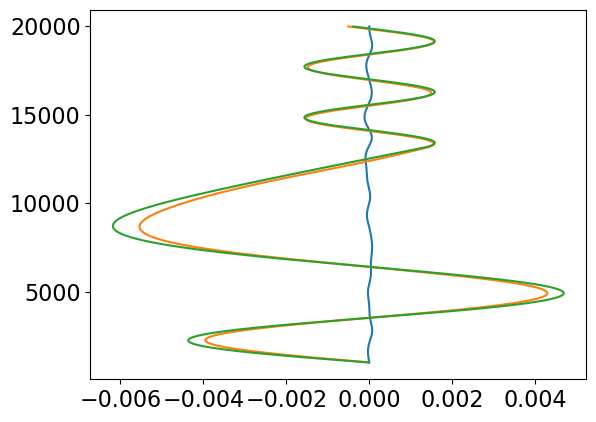

In [268]:
plt.plot(np.real(whom2),Ref.zz)
plt.plot(np.real(testt2),Ref.zz)
plt.plot(wwtrue,Ref.zz)

## Now with the CZBP

In [56]:
def to_minimize(coefs,lambdai,wi,Zbp_r,Zbp_i,k,hhatk,U0,TTref):
    nc = len(coefs)//2
    coefs2 = coefs[:nc]+1j*coefs[nc:]
    n = len(wi[0])
    b = 1j*np.zeros(n)
    
    ww = np.dot(coefs2,wi)
    Zbp_r.ww = np.real(ww)
    Zbp_i.ww = np.imag(ww)
    Zbp_r.integrate();Zbp_r.calc_precip();Zbp_r.calc_Q()
    Zbp_i.integrate();Zbp_i.calc_precip();Zbp_i.calc_Q()
    
    Qb = (Zbp_r.Q+1j*Zbp_i.Q)*g/(Zbp_r.rho_*cp*TTref)
    b[1:-1] = Qb[1:-1]/U0**2
    return 1e15*np.sum(np.abs(np.dot(lambdai*coefs2,wi) - b)**2)

In [78]:
zz = np.arange(1000,20e3,DZ); U0=10.; k0 = 2*np.pi/100e3
ww = -np.sin(np.pi*zz/20e3)*0.01
alpha = Ref.rho_*k0*U0

Refr = ZBPls(zz,ww,-alpha,Ref.TT,Ref.qq); Refr.integrate()

In [80]:
zz = np.arange(1000,20e3,DZ); U0=10.
ww = 0.*zz
k0 = 2*np.pi/10e3
alpha = Ref.rho_*k0*U0

Refr = ZBPls(zz,ww,-alpha,Ref.TT,Ref.qq); Refr.integrate()
Refi = ZBPls(zz,ww,alpha,Ref.TT,Ref.qq); Refi.integrate()

coefs = np.zeros(2*len(wi))
%time test = minimize(to_minimize,coefs,args=(mui,wi,Refr,Refi,k0,0.01,10.,Ref.TT),bounds=[(-0.01,0.01)]*len(coefs),method='Nelder-Mead')#,method='L-BFGS-B',jac='3-point',options={'ftol':1e-20,'gtol':1e-10})


ValueError: ('issue in RH root, roots = ', array([5.86695440e+58    +0.j        , 9.69705585e+00+16461.62100183j,
       9.69705585e+00-16461.62100183j]), 'w=', 4.715070634853703e-57, 'a=', -0.004101913599385009)

In [ ]:
coefs2= test.x[:len(wi)]+1j*test.x[len(wi):]
whom2 = np.dot(coefs2,wi)

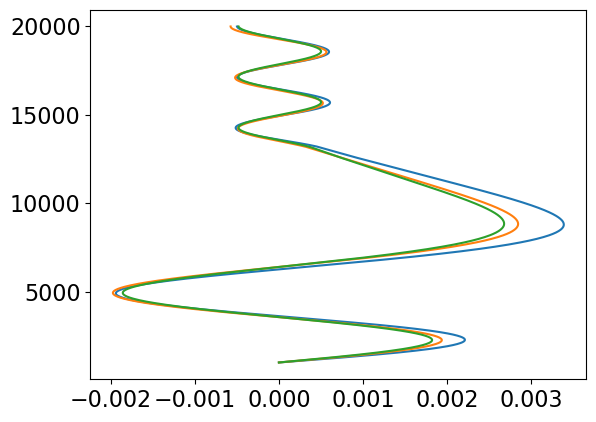

In [650]:
#plt.plot(np.real(whom),Ref.zz)
plt.plot(np.real(whom2),Ref.zz)
plt.plot(np.real(testt2),Ref.zz)
plt.plot(wwtrue-ww0,Ref.zz)
#plt.plot(np.real(wtot),Ref.zz)
#plt.plot(np.real(wwtrue),Ref.zz)

# Coupling as $d_z^2\tilde w -k^2\tilde w = i k \tilde b / U$

In [292]:
def make_A(z,lz2,k):
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(-k**2*np.ones(n))
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -=  dz*1j* mtop    
    
    return A

def gw_mode_forced(z,lz2,k,hhatk,U0,rhs,K0):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = q_hat, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    A = make_A(z,lz2,k)
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= dz**2 * rhs[1:-1]
    
    return np.linalg.solve(A+K0**2*np.eye(n),b)

def nmodes_forced(z,mui,wi,mi,hhatk,U0,rhs):
    n = len(z)
    dz = z[1]-z[0]

    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= dz**2 * rhs[1:-1]
    
    coefs_true = np.dot(np.conj(mi),b)/mui
    return np.dot(coefs_true,wi)

In [198]:
lambdai,li,vi = spl.eig(make_A(Ref.zz,Ref.N2/U0**2,k0),left=True)
order = np.argsort(-np.real(lambdai))
lambdai = lambdai[order]
vi = vi[:,order].T; li = li[:,order].T
li = li/np.diagonal(np.dot(np.conj(li),vi.T))[:,None]


Text(0.5, 1.0, 'W, Re and Im')

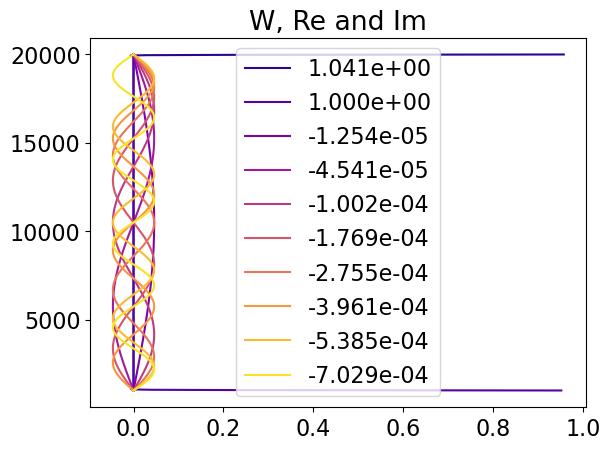

In [199]:
N=10
colors = plt.cm.plasma(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(vi[i]),Ref.zz,color=colors[i],label='%.3e'%np.real(lambdai[i]))
plt.legend()
plt.title("W, Re and Im")
#plt.xscale('log')

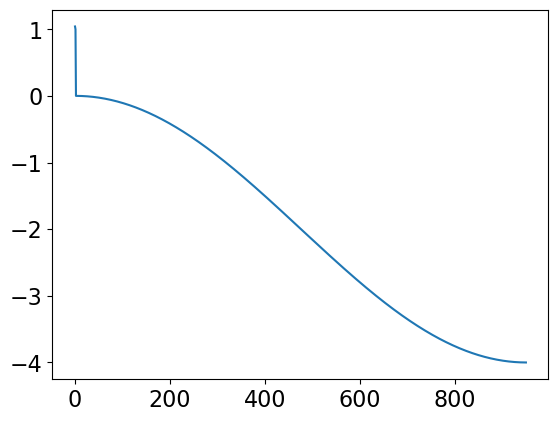

In [218]:
plt.plot(lambdai)

In [293]:
def couple_simple(Zbpa,k,hhatk,U0,K0,ww=None,Nmodes=-1,niter=30):
    TTref = Zbpa.TT
    N2_ref = (g/TTref *(np.gradient(TTref,Zbpa.zz)+g/cp))
    lz2 = N2_ref/U0**2
    
    if ww is None:
        ww=0*Zbpa.zz*1j
    ww1 = ww
    
    Tprime = 0*Zbpa.zz*1j
    
#    if Nmodes>0:
#        lambdai,li,vi = spl.eig(make_A(Zbp_r.zz,N2_ref/U0**2,k),left=True)
#        order = np.argsort(-np.real(lambdai))
#        lambdai = lambdai[order]
#        vi = vi[:,order].T; li = li[:,order].T
#        li = li/np.diagonal(np.dot(np.conj(li),vi.T))[:,None]
#        
#        mui = lambdai[:N]
#        wi = vi[:N]
#        mi = li[:N]
    
    amps = []
    ws = []
    c=1.

    for i in range(niter):
        print(i, end = ' ')
        try:
            Tprime1=Tprime
            Tprime = - TTref * N2_ref * ((1-c)*ww1 + c*ww) / (1j*k*U0*g)
            rhs = 1j * k * g / U0 * Tprime /TTref + K0**2*((1-c)*ww1 + c*ww)
    
            ww1 = ww
            if Nmodes<=0:
                ww = gw_mode_forced(Zbpa.zz,lz2,k,hhatk,U0,rhs,K0)
            else:
                ww = nmodes_forced(Zbpa.zz,lz2,k,hhatk,U0,rhs)
            
            amps.append(np.sum(np.abs(ww)**2))
            ws.append(ww)
        except ValueError:
            return amps,ws

    return amps,ws


In [300]:
%%time
U0=10.; k0 = 2*np.pi/100e3
amps,ws = couple_simple(Ref,k0,0.01,U0,1e10,niter=20)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 CPU times: user 1.27 s, sys: 748 ms, total: 2.02 s
Wall time: 1.02 s


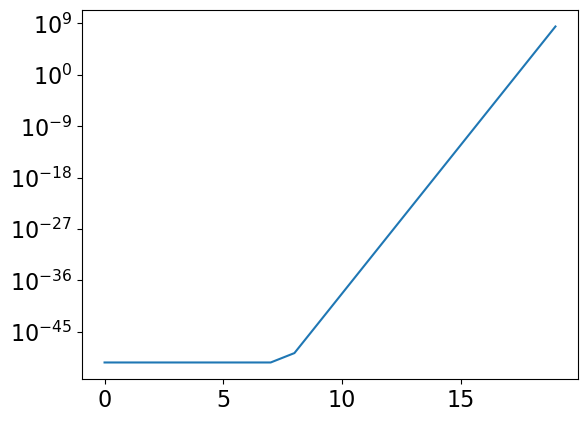

In [301]:
plt.plot(amps)
plt.yscale('log')

Text(0.5, 1.0, 'W, Re and Im')

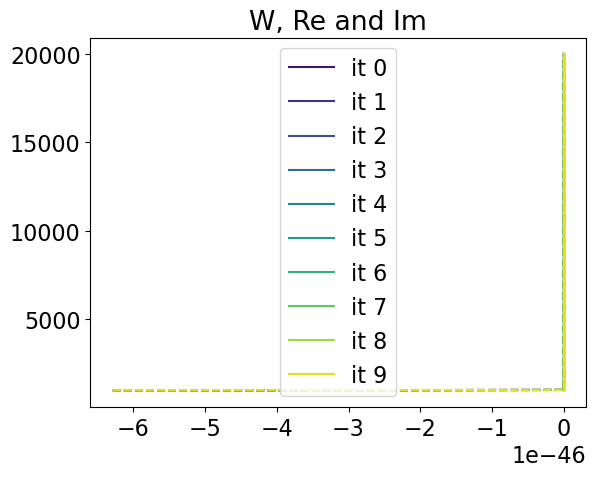

In [271]:
N=10
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i],label='it %i'%i)
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
plt.legend()
plt.title("W, Re and Im")

# Coupling as $d_z^2\tilde w + (l^2-k^2)\tilde w = \tilde Q (\tilde w) / U^2$

In [272]:
def make_A(z,lz2,k):
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -=  dz*1j* mtop    
    
    return A

def gw_mode_forced(z,lz2,k,hhatk,U0,K0,qhatk):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = q_hat, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    A = make_A(z,lz2,k)
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= dz**2 * qhatk[1:-1]
    
    return np.linalg.solve(A-K0**2*np.eye(n),b)

def nmodes_forced(z,mui,wi,mi,hhatk,U0,qhatk):
    n = len(z)
    dz = z[1]-z[0]

    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= dz**2 * qhatk[1:-1]
    
    coefs_true = np.dot(np.conj(mi),b)/mui
    return np.dot(coefs_true,wi)

In [274]:
def couple(Zbp_r,Zbp_i,k,hhatk,U0,K0,Nmodes=-1,niter=30):
    TTref = Zbp_r.TTref
    qqref = Zbp_r.qqref

    N2_ref = (g/TTref *(np.gradient(TTref,Zbp_r.zz)+g/cp))
    lz2 = N2_ref/U0**2
    
    ww=0*Zbp_r.zz*1j
    ww1 = ww
    ww0 = ww
    
    if Nmodes>0:
        lambdai,li,vi = spl.eig(make_A(Zbp_r.zz,N2_ref/U0**2,k),left=True)
        order = np.argsort(-np.real(lambdai))
        lambdai = lambdai[order]
        vi = vi[:,order].T; li = li[:,order].T
        li = li/np.diagonal(np.dot(np.conj(li),vi.T))[:,None]
        
        mui = lambdai[:N]
        wi = vi[:N]
        mi = li[:N]
    
    ws=[];Qs=[]
    c=0.6

    for i in range(niter):
        print(i, end = ' ')
        try:
            Zbp_r.ww = np.real(c*ww+(1-c)*ww1)
            Zbp_i.ww = np.imag(c*ww+(1-c)*ww1)
            Zbp_r.integrate();Zbp_r.calc_precip();Zbp_r.calc_Q()
            Zbp_i.integrate();Zbp_i.calc_precip();Zbp_i.calc_Q()
            
            Qb = (Zbp_r.Q+1j*Zbp_i.Q)*g/(Zbp_r.rho_*cp*TTref)
            #Qb = gaussian_filter(Qb,30)
            ww_ = c*ww+(1-c)*ww1
            ww1 = ww
            
            if Nmodes<=0:
                ww = gw_mode_forced(Zbp_r.zz,lz2,k,hhatk,U0,K0,Qb/U0**2 - K0**2*ww_)
            else:
                ww = nmodes_forced(Zbp_r.zz,mui,wi,mi,hhatk,U0,Qb/U0**2)
            
            ws.append(ww)
            Qs.append(Qb/U0**2)
        except ValueError:
            return ws,Qs

    return ws,Qs


In [285]:
%%time
U0=10.; k0 = 2*np.pi/100e3
ww = Ref.zz*0
alpha = Ref.rho_*k0*U0

Refr = ZBPls(Ref.zz,ww,-alpha,Ref.TT,Ref.qq); Refr.integrate()
Refi = ZBPls(Ref.zz,ww,alpha,Ref.TT,Ref.qq); Refi.integrate()
ws,Qs = couple(Refr,Refi,k0,0.001,U0,1e3,niter=5)


0 1 2 3 4 CPU times: user 43.5 s, sys: 568 ms, total: 44.1 s
Wall time: 43.4 s


Text(0.5, 1.0, 'W, Re and Im')

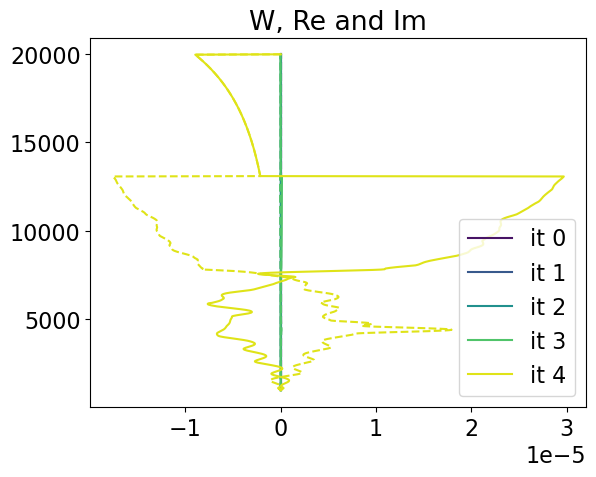

In [286]:
N=5
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i],label='it %i'%i)
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
plt.legend()
plt.title("W, Re and Im")

In [148]:
%%time
U0=10.; k0 = 2*np.pi/100e3
ww = Ref.zz*0
alpha = Ref.rho_*k0*U0

Refr = ZBPls(Ref.zz,ww,-alpha,Ref.TT,Ref.qq); Refr.integrate()
Refi = ZBPls(Ref.zz,ww,alpha,Ref.TT,Ref.qq); Refi.integrate()
ws,Qs = couple(Refr,Refi,k0,0.001,U0,Nmodes=5,niter=5)


0 1 2 3 4 CPU times: user 1min 12s, sys: 1.35 s, total: 1min 14s
Wall time: 1min 11s


Text(0.5, 1.0, 'W, Re and Im')

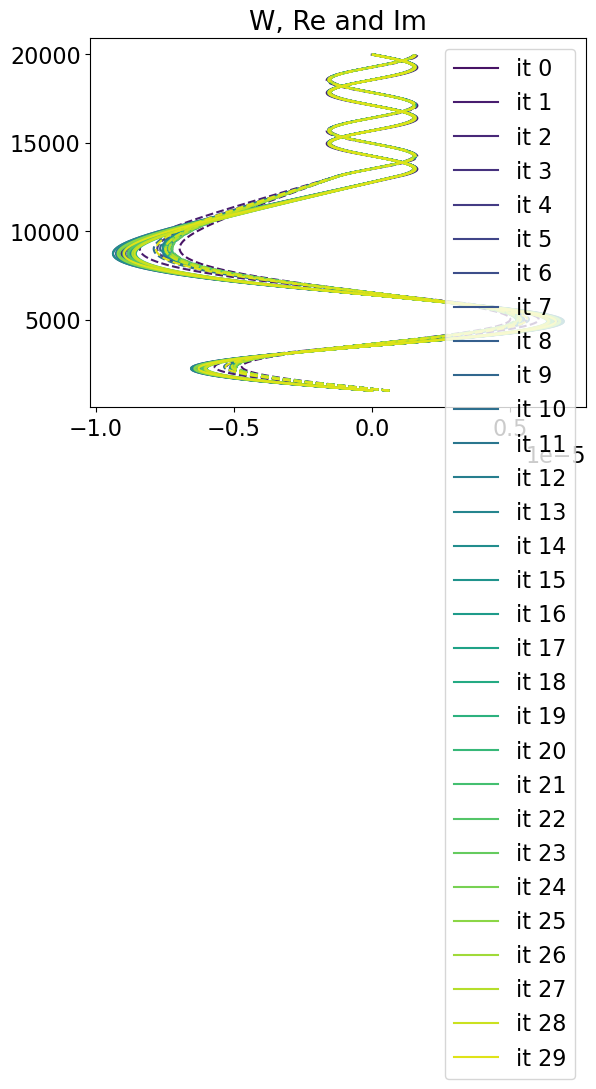

In [223]:
N=30
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i],label='it %i'%i)
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
plt.legend()
plt.title("W, Re and Im")

Text(0.5, 1.0, 'W, Re and Im')

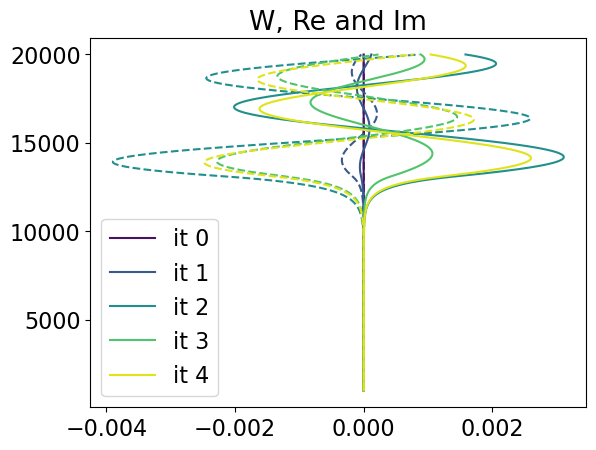

In [149]:
N=5
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i],label='it %i'%i)
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
plt.legend()
plt.title("W, Re and Im")

Text(0.5, 1.0, 'W, Re and Im')

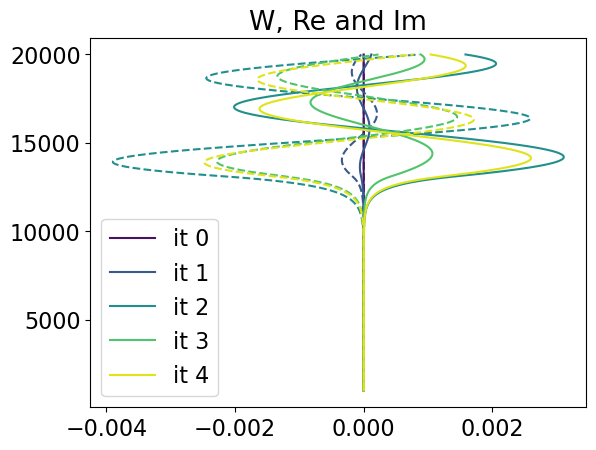

In [119]:
N=5
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i],label='it %i'%i)
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
plt.legend()
plt.title("W, Re and Im")

Text(0.5, 1.0, 'W, Re and Im')

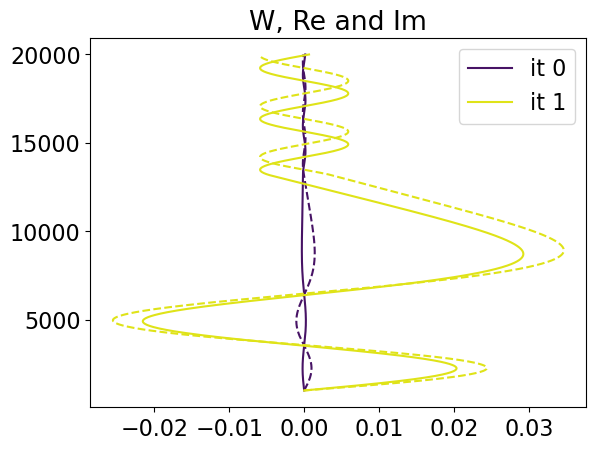

In [95]:
N=2
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i],label='it %i'%i)
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
plt.legend()
plt.title("W, Re and Im")

Text(0.5, 1.0, 'Qb/U^2, Re and Im')

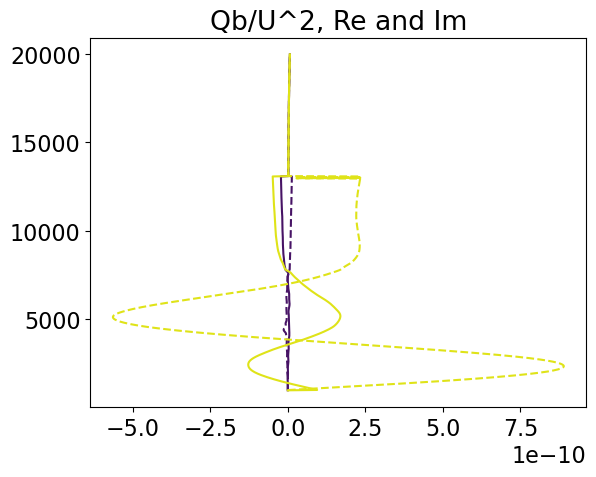

In [96]:
N=2
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(Qs[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(Qs[i]),Ref.zz,color=colors[i],linestyle='--')
plt.title("Qb/U^2, Re and Im")

In [225]:
lambdai,li,vi = spl.eig(spl.inv(make_A(Ref.zz,Ref.N2/U0**2,k0)),left=True)
order = np.argsort(-np.real(lambdai))
lambdai = lambdai[order]
vi = vi[:,order].T;li = li[:,order].T
li = li/np.diagonal(np.dot(np.conj(li),vi.T))[:,None]

(-0.001, 0.001)

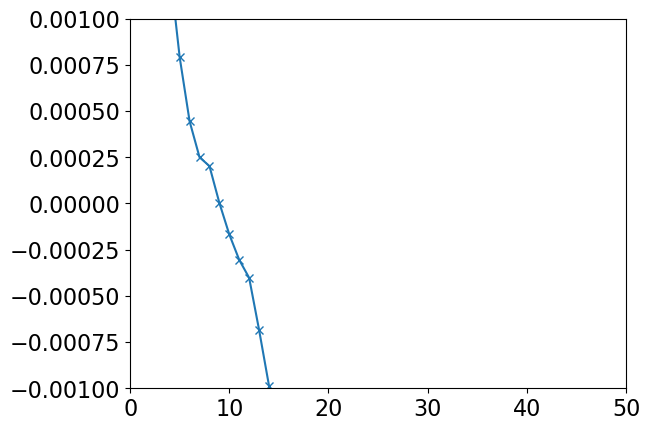

In [87]:
plt.plot(np.real(lambdai),'-x')
plt.xlim(0,50)
plt.ylim(-1e-3,1e-3)

Text(0.5, 1.0, 'W, Re and Im')

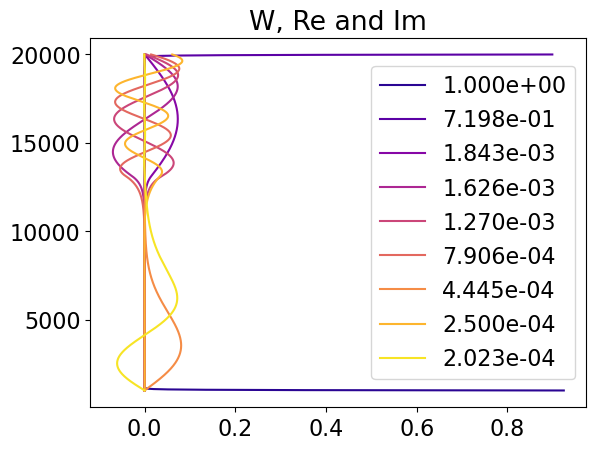

In [108]:
N=9
colors = plt.cm.plasma(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(vi[i]),Ref.zz,color=colors[i],label='%.3e'%np.real(lambdai[i]))
plt.legend()
plt.title("W, Re and Im")

Text(0.5, 1.0, 'W, Re and Im')

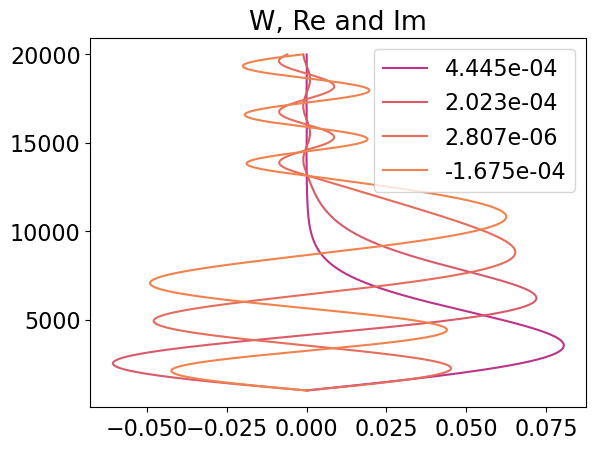

In [125]:
N=15
colors = plt.cm.plasma(np.linspace(0.05,0.95,N))
for i in (6,8,9,10):
    plt.plot(np.real(vi[i]),Ref.zz,color=colors[i],label='%.3e'%np.real(lambdai[i]))
plt.legend()
plt.title("W, Re and Im")

In [83]:
Refr = ZBPls(Ref.zz,ww,-alpha,Ref.TT,Ref.qq); Refr.integrate()
Zbp_r.ww = np.real(c*ww+(1-c)*ww1)
            Zbp_i.ww = np.imag(c*ww+(1-c)*ww1)
            Zbp_r.integrate();Zbp_r.calc_precip();Zbp_r.calc_Q()

2.807003479320495e-06

In [55]:
N=30
mui = lambdai[:N]
wi = vi[:N]
mi = li[:N]


# Coupling as $d_z^2\tilde w + (l^2-k^2)\tilde w - K_0^2 \tilde w = \tilde Q (\tilde w) / U^2 - K_0^2 \tilde w$

In [29]:
from scipy.integrate import cumtrapz

In [44]:
def gw_mode_forced_K0(z,lz2,k,K0,hhatk,U0,qhatk):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = q_hat, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(lz2-k**2-K0**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -=  dz*1j* mtop
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= dz**2 * qhatk[1:-1]
    
    return np.linalg.solve(A,b)
    A = csc_matrix(A)
    return spsolve(A,b)

In [33]:
from scipy.ndimage import gaussian_filter
def couple_K0(Zbp_r,Zbp_i,k,K0,hhatk,U0):
    TTref = Zbp_r.TT
    qqref = Zbp_r.qq

    N2_ref = (g/TTref *(np.gradient(TTref,Zbp_r.zz)+g/cp))
    lz2 = N2_ref/U0**2
    
    ww=0*Zbp_r.zz*1j
    ww1 = ww
    ww0 = ww
    
    ws=[];Qs=[]
    c=0.6

    for i in range(30):
        print(i, end = ' ')
        try:
            Zbp_r.ww = np.real(c*ww+(1-c)*ww1)
            Zbp_i.ww = np.imag(c*ww+(1-c)*ww1)
            Zbp_r.integrate();Zbp_r.calc_precip();Zbp_r.calc_Q()
            Zbp_i.integrate();Zbp_i.calc_precip();Zbp_i.calc_Q()
            
            Qb = (Zbp_r.Q+1j*Zbp_i.Q)*g/(Zbp_r.rho_*cp*TTref)
            Qb = gaussian_filter(Qb,30)
            ww_ = c*ww+(1-c)*ww1
            ww1 = ww
            ww = gw_mode_forced_K0(Zbp_r.zz,lz2,k,K0,hhatk,U0,Qb/U0**2 - K0**2*ww1)
            #stratosphere = Zbp_r.zz>11e3#(Zbp_r.TT<=Tt)|(Zbp_i.TT<=Tt)
            #ww[stratosphere]=0.
            
            #matching_fn = 1/(1+np.exp((Ref.zz-10000)/100))*(Zbp_r.zz<11e3)
            #ww*=matching_fn
            
            ws.append(ww)
            Qs.append(Zbp_r.Q+1j*Zbp_i.Q)
        except ValueError:
            return ws,Qs

    #xx = np.arange(-1000,1000)*1e3
    #plt.plot(xx/1000, np.cos(k*xx))
    #w_full = np.real(ww[None,:]*np.exp(1j*k*xx[:,None]))
    #w_xr = xr.DataArray(w_full,coords={'distance_from_mtn':xx/1000,'altitude':Zbp_r.zz/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',Zbp_r.pp/100)})
    return ws,Qs

In [21]:
#from orographicConvectionTheory.orographicConvectionTheory import topographic_profile
#
#xx,hx = topographic_profile('cos')
#h_hat = np.fft.fft(hx)

In [38]:
%%time
zz = np.arange(1000,20e3,DZ); U0=10.; k0 = 2*np.pi/100e3
ww = zz*0
alpha = Ref.rho_*k0*U0

Refr = ZBPls(zz,ww,-alpha,Ref.TT,Ref.qq); Refr.integrate()
Refi = ZBPls(zz,ww,alpha,Ref.TT,Ref.qq); Refi.integrate()
ws,Qs = couple_K0(Refr,Refi,k0,1.5e-2,1.,U0)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 CPU times: user 48.7 s, sys: 3.57 s, total: 52.3 s
Wall time: 47.4 s


In [41]:
w_unforced = gw_mode_forced(Ref.zz,Ref.N2/U0**2,k0,0.,1.,U0,np.zeros(len(Ref.zz)))

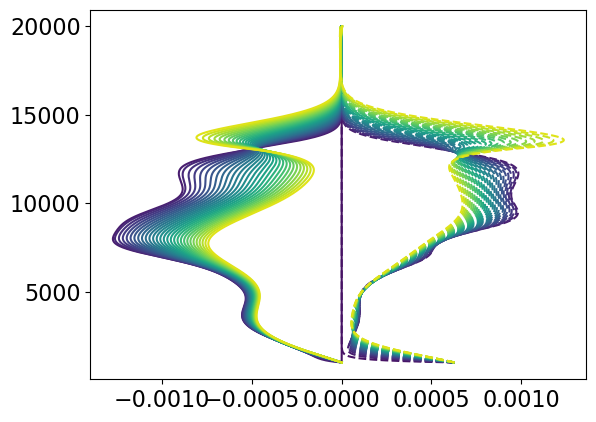

In [37]:
##with 8e-3 regularization
N=30
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
#plt.plot(amps)
#plt.plot(amps2)
#plt.yscale('log')

#plt.ylim(990,1010)
#plt.xlim(-1e-3,1e-3)

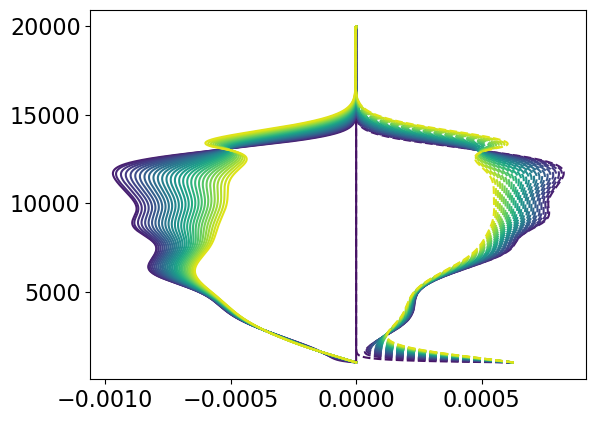

In [35]:
##with 1e-2 regularization
N=30
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
#plt.plot(amps)
#plt.plot(amps2)
#plt.yscale('log')

#plt.ylim(990,1010)
#plt.xlim(-1e-3,1e-3)

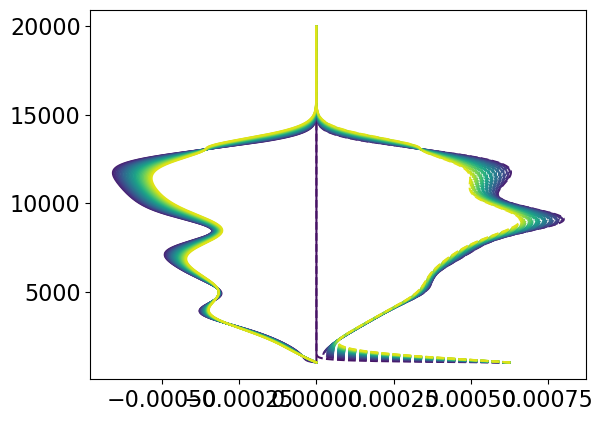

In [39]:
##with 1.5e-2 regularization
N=30
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')

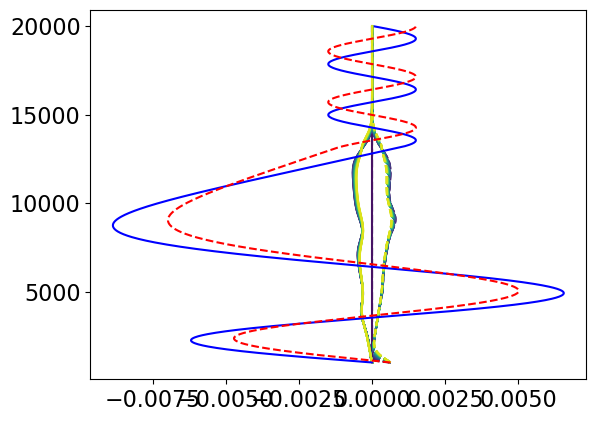

In [43]:
##with 1.5e-2 regularization
N=30
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    plt.plot(np.real(ws[i]),Ref.zz,color=colors[i])
    plt.plot(np.imag(ws[i]),Ref.zz,color=colors[i],linestyle='--')
    
plt.plot(np.real(w_unforced),Ref.zz,color='b')
plt.plot(np.imag(w_unforced),Ref.zz,color='r',linestyle='--')
#plt.plot(amps)
#plt.plot(amps2)
#plt.yscale('log')

#plt.ylim(990,1010)
#plt.xlim(-1e-3,1e-3)

# Linear gravity wave with a limited number of modes

In [148]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

In [144]:
from orographicPrecipitation.observationsAndERA5.linearWaveModels import *
from tools.generalTools import compute_N
from tools.wrfHrTools import change_coords_pl
from scipy.interpolate import interp1d
class SimulationCustom(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.T_PL_MEAN  = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
W10S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000')


sample_pout = xr.open_dataset("/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/wrfpout_d01_1970-03-17_01_00_00")
Z_all = change_coords_pl(sample_pout,sample_pout.GHT_PL).sel(distance_from_mtn=slice(-2000,-5000))
W10S300.Z_PL_SNAP = Z_all.where(Z_all>0).mean(['Time','south_north','distance_from_mtn'])


W10S300.N_PL_MEAN = compute_N(W10S300.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')


Text(0.5, 0, 'N (s^-1)')

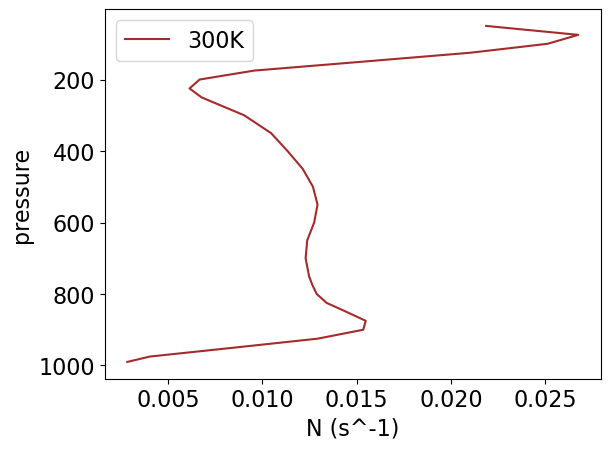

In [145]:
W10S300.N_PL_MEAN.plot(y='pressure',yincrease=False,color='brown',label='300K')
plt.legend()
plt.xlabel('N (s^-1)')

In [240]:
def calc_w_general(Sim):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[1000:3001:6]
    hx = hx[1000:3001:6]
    
    thresh = 3e-5
    hx = np.fft.ifft(np.fft.fft(hx)*(np.abs(kk)<thresh))*1.2
    #hx = np.fft.ifft(np.fft.fft(hx)*(np.abs(kk)==kk[30]))*70
    
    z=np.linspace(0,20e3,100)
    p = interp1d(Sim.Z_PL_SNAP,Sim.Z_PL_SNAP.pressure,kind='linear',fill_value='extrapolate')(z)
    N = interp1d(Sim.Z_PL_SNAP,Sim.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
    U = 10.*z**0
    w_general = linear_w_generalized(xx,hx,z,U,N)
    return w_general.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})

In [147]:
w_300_general = calc_w_general(W10S300)

0 500 1000 1500 2000 

In [214]:
w_300_general2 = calc_w_general(W10S300)

0 

In [241]:
w_300_general3 = calc_w_general(W10S300)

0 

In [237]:
w_300_general4 = calc_w_general(W10S300)

0 

In [189]:
xx_ref ,hx_ref = topographic_profile('cos',A=500)
xx = xx_ref[1000:3001:6]
hx = hx_ref[1000:3001:6]
kk = k_vector(len(xx),xx[1]-xx[0])

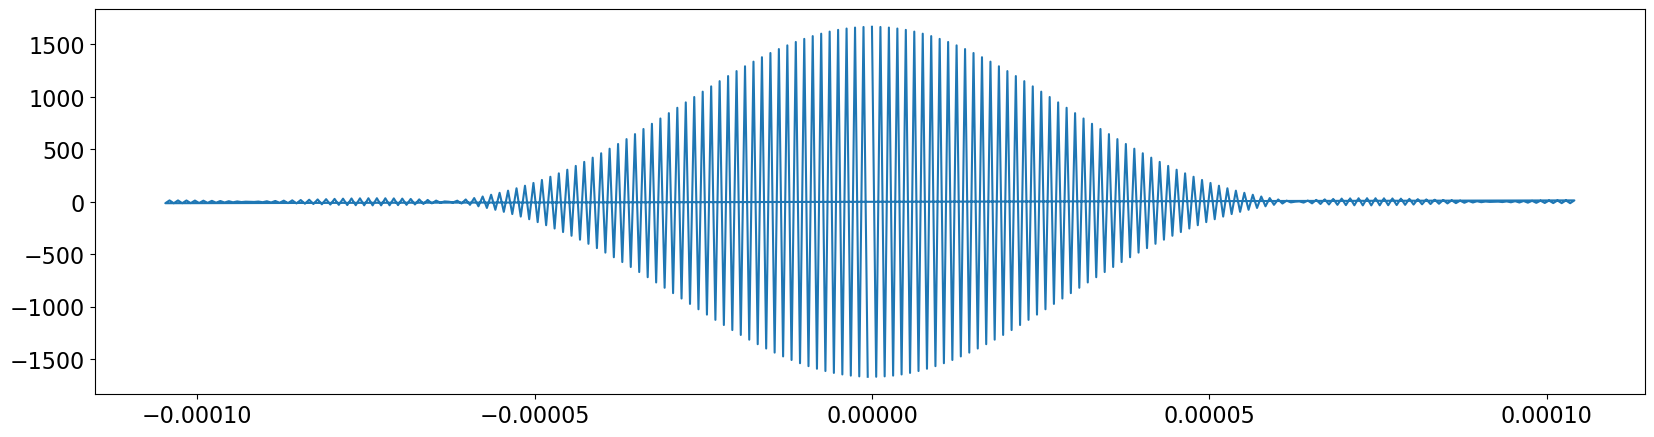

In [193]:
plt.figure(figsize=(20,5))
plt.plot(kk,np.fft.fft(hx))

number of modes: 95


(-1000000.0, 1000000.0)

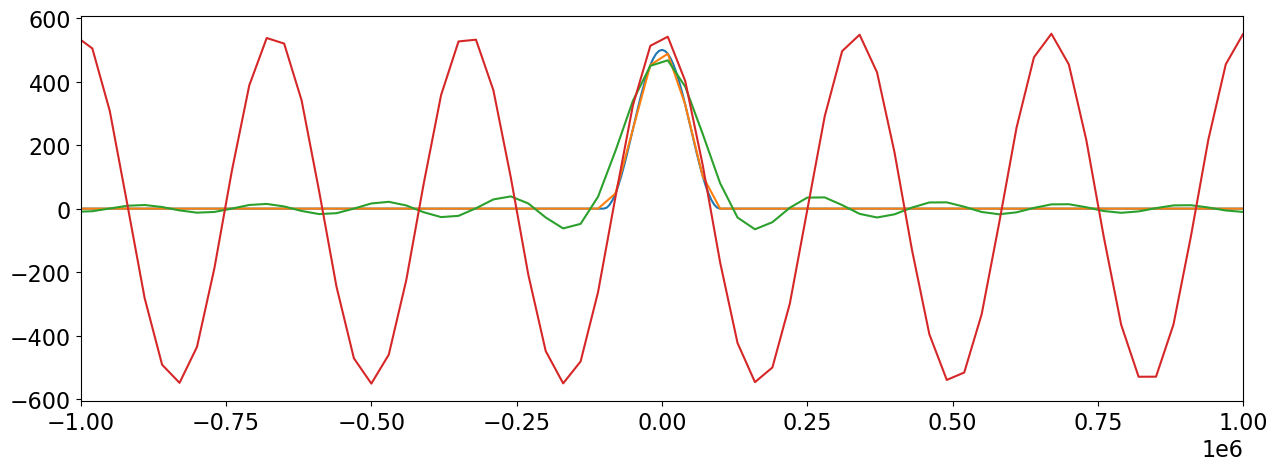

In [239]:
plt.figure(figsize=(15,5))
thresh = 3e-5
plt.plot(xx_ref,hx_ref)
plt.plot(xx,hx)
plt.plot(xx,np.fft.ifft(np.fft.fft(hx)*(np.abs(kk)<thresh))*1.2)
plt.plot(xx,np.fft.ifft(np.fft.fft(hx)*(np.abs(kk)==kk[30]))*70)
print("number of modes:",(np.abs(kk)<thresh).sum())
plt.xlim(-1e6,1e6)

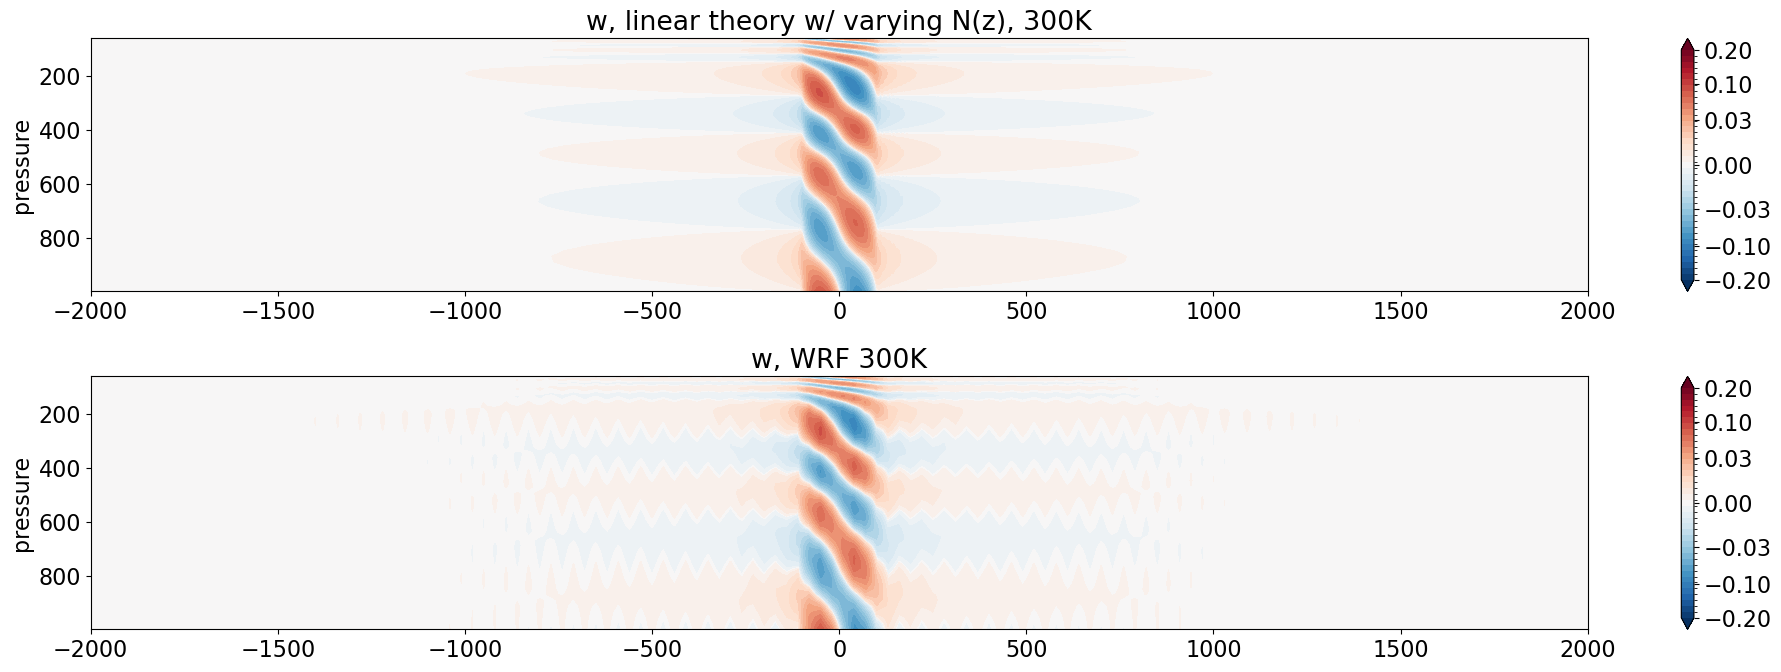

In [217]:
fig,axs = plt.subplots(2,1,figsize=(20,7))
w_300_general.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_300_general2.plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.set_xlabel("")
axs[0].set_title('w, linear theory w/ varying N(z), 300K')
axs[1].set_title('w, WRF 300K')
fig.tight_layout()

In [247]:
z=np.linspace(0,20e3,100)
N = interp1d(W10S300.Z_PL_SNAP,W10S300.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
U = 10.*z**0
T_300_general  = w_to_Tprime(w_300_general ,U,N)
T_300_general2 = w_to_Tprime(w_300_general2,U,N)
T_300_general3 = w_to_Tprime(w_300_general3,U,N)
T_300_general4 = w_to_Tprime(w_300_general4,U,N)

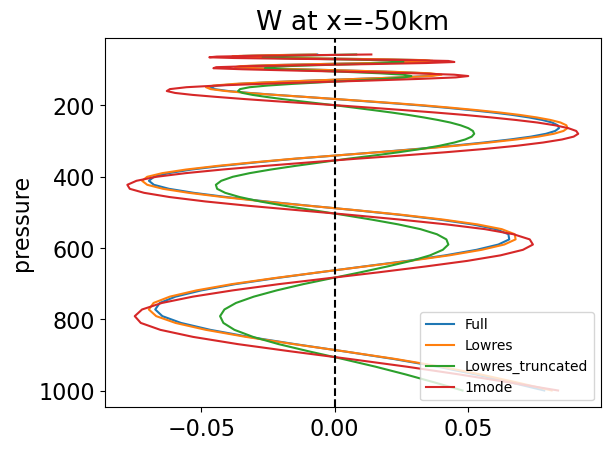

In [253]:
w_300_general .sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Full')
w_300_general2.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres')
w_300_general3.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres_truncated')
w_300_general4.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='1mode')

plt.axvline(0.,color='k',linestyle='--')
plt.title('W at x=-50km')
plt.legend(fontsize=10)

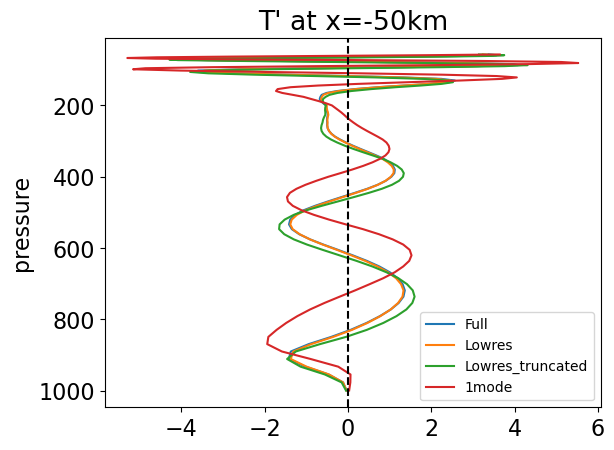

In [255]:
T_300_general .sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Full')
T_300_general2.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres')
T_300_general3.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres_truncated')
T_300_general4.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='1mode')

plt.axvline(0.,color='k',linestyle='--')
plt.title("T' at x=-50km")
plt.legend(fontsize=10)